Import libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import Perceptron

Load the dataset Abalone which is used in HW2. I used this dataset because I will compare the results with the results in HW2.

In [3]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Read the dataset
abalone = pd.read_csv("abalone.data", header=None, names=column_names)

abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Drop the categorical feature

In [4]:
abalone = abalone.drop('Sex', axis=1)

In [5]:
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
Counter(abalone.Rings)

Counter({15: 103,
         7: 391,
         9: 689,
         10: 634,
         8: 568,
         20: 26,
         16: 67,
         19: 32,
         14: 126,
         11: 487,
         12: 267,
         18: 42,
         13: 203,
         5: 115,
         4: 57,
         6: 259,
         21: 14,
         17: 58,
         22: 6,
         1: 1,
         3: 15,
         26: 1,
         23: 9,
         29: 1,
         2: 1,
         27: 2,
         25: 1,
         24: 2})

This dataset suffers from class imbalance problem.

In [7]:
abalone.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

I will use another labelling that I used in HW2. Instead of having 29 classes, we will have only 3 classes wtih this mapping.

In [9]:
class_mapping = {
    # Young classes (0-9)
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,

    # Medium classes (10-19)
    10: 2,
    11: 2,
    12: 2,
    13: 2,
    14: 2,
    15: 2,
    16: 2,
    17: 2,
    18: 2,
    19: 2,

    # Old classes (20-29)
    20: 3,
    21: 3,
    22: 3,
    23: 3,
    24: 3,
    25: 3,
    26: 3,
    27: 3,
    28: 3,
    29: 3
}

Prepare the data as training and validation

In [10]:
X = abalone[abalone.columns[:-1]]
y = abalone.Rings

# Map y values to get 3 classes
y_grouped = [class_mapping[label] for label in y]

label_distribution = Counter(y_grouped)
print(label_distribution)

# Split dataset as I did in HW2
X_train, X_val, y_train, y_val = train_test_split(
        X, y_grouped, test_size=0.1, random_state=42
    )

# Convert numpy array for Random Forest
X_train_numpy = X_train.values
y_train_numpy = np.asarray(y_train)
X_val_numpy = X_val.values
y_val_numpy = np.asarray(y_val)

Counter({1: 2096, 2: 2019, 3: 62})


# AdaBoost and MLP

Define the MLP

In [12]:
def model():
    # Define neural network architecture
    model = Sequential()
    # There are 7 feature and the hidden layer has 5 neurons
    model.add(Dense(5, input_dim=7, activation='relu'))
    # There are only 3 classes in the dataset
    model.add(Dense(3, activation='softmax'))
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

Create an estimator to give the model to AdaBoost.

In [13]:
estimator = KerasClassifier(build_fn=model, epochs=10, verbose=0)

Train an AdaBoost model by using MLP as base classifer.

In [ ]:
boosted = AdaBoostClassifier(estimator=estimator)
boosted.fit(X_train, y_train)
y_pred = boosted.predict(X_val)

Evaluate the results by using accuracy and confusion matrix

AdaBoost Ensemble Learner with MLP as Base Classifier Performance:
Accuracy: 0.7990430622009569


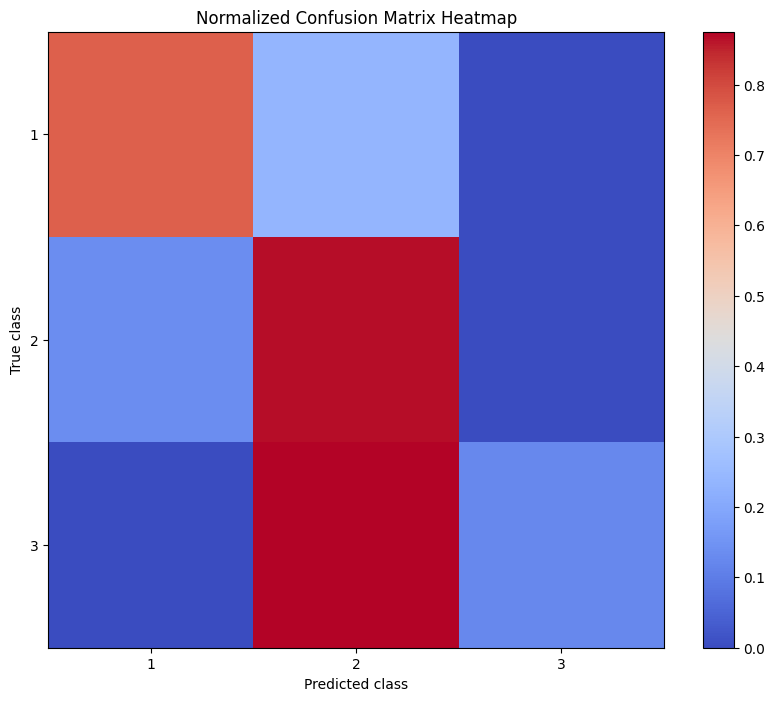

In [15]:
# Show results
labels = [1, 2, 3]
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred, normalize='true', labels=labels)

print("AdaBoost Ensemble Learner with MLP as Base Classifier Performance:")
print("Accuracy:", accuracy)

# Create a heatmap for the normalized confusion matrix
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('coolwarm')
heatmap = plt.imshow(conf_matrix, cmap=cmap)
plt.colorbar(heatmap)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Normalized Confusion Matrix Heatmap')

# Show the plot
plt.show()


Its accuracy, 0.80, is reasonably great. Confusion matrix shows that it can't predict the class 3 because there is a few data for the class 3. This is the result of class imbalance.

# Random Forest and Perceptron

I am using the same implementation of DT and RF in HW2. Therefore, there is a need for attribute vector.

In [16]:
# get the attribute types for each one
attribute_types = []

# iterate over each feature column in the DataFrame
for col in abalone.columns[:-1]:
    # check the data type of the column
    if abalone[col].dtype in [np.float64, np.int64]:
        attribute_types.append(1)  # Type 1: Numeric
    else:
        attribute_types.append(2)  # Type 2: Categorical

print("\nAttribute types (1: numeric, 2: categorical):")
print(attribute_types)


Attribute types (1: numeric, 2: categorical):
[1, 1, 1, 1, 1, 1, 1]


Define Decision Tree class with the modification for Perceptron part. Basically, it uses a Perceptron instead of Information Gain to find the best split.

In [17]:
# Node class of the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature # the chosen feature
        self.threshold = threshold # the chosen threshold
        self.left = left # the left tree
        self.right = right # the right tree
        self.value = value # the class label

    def is_leaf_node(self):
        return self.value is not None

# Decision Tree class
class DecisionTree:
    def __init__(self, max_depth=None, pruning=None, n_features=None):
        self.min_samples_split=2 # the minimum sample number to split
        self.max_depth=max_depth # max depth for pre-pruning
        self.pruning=pruning # pruning type : None, 1 (pre), 2 (post)
        self.n_features=n_features # number of features as percentage (for random forest)
        self.root=None

    def fit(self, X, y, attribute_types, X_val, y_val):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],int((self.n_features*X.shape[1])/100))
        print(f"Number of features: {self.n_features}")
        self.root = self._grow_tree(X, y, attribute_types)

        # post-prune the tree
        if self.pruning == 2:
            self._post_prune(self.root, X_val, y_val)

    def _grow_tree(self, X, y, attribute_types, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if self.pruning == None or self.pruning == 2:
            if (n_labels==1 or n_samples<self.min_samples_split):
                leaf_value = self._most_common_label(y)
                return Node(value=leaf_value)
        else: # additionally, check the depth for pre-pruning
            if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
                leaf_value = self._most_common_label(y)
                return Node(value=leaf_value)

        # get features (for random forest)
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs, attribute_types)

        # create child nodes
        if attribute_types[best_feature] == 2:  # 2 indicates a categorical feature
            left_idxs, right_idxs = self._split_categorical(X[:, best_feature], best_thresh)
        else:
            left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # handle empty splits
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            # return a leaf node with the most common label in y
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], attribute_types, depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], attribute_types, depth+1)

        return Node(best_feature, best_thresh, left, right)



    ##################################################################
    # This part is modified for Perceptron
    # Instead of using Information Gain, it uses Perceptron


    def _best_split(self, X, y, feat_idxs, attribute_types):
        # Find the best split by using perceptron
        best_gain = -float('inf')
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                accuracy = self._perceptron_split(X, y, X_column, thr, attribute_types[feat_idx])
                if accuracy > best_gain:  # Now, we have accuracy instead of gain
                    best_gain = accuracy
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _perceptron_split(self, X, y, X_column, threshold, attribute_type):
        left_idxs, right_idxs = self._split(X_column, threshold)

        # No need to continue if the dataset is not splitted
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # If there is only one class, we don't need to use perceptron
        if len(np.unique(y[left_idxs])) == 1 or len(np.unique(y[right_idxs])) == 1:
            return 0

        # Basically, it splits the dataset and creates a perceptron
        # Then, we get accuracy from the perceptron for both left and right splits
        # It compares if the current accuracy is higher than the best

        # Train perceptron for left node
        left_X, left_y = X[left_idxs], y[left_idxs]
        perceptron_left = Perceptron(max_iter=20) # max iteration is 20 for runtime efficiency
        perceptron_left.fit(left_X, left_y)

        # Train perceptron for right node
        right_X, right_y = X[right_idxs], y[right_idxs]
        perceptron_right = Perceptron(max_iter=20) # max iteration is 20 for runtime efficiency
        perceptron_right.fit(right_X, right_y)

        # Calculate accuracy
        left_accuracy = perceptron_left.score(left_X, left_y)
        right_accuracy = perceptron_right.score(right_X, right_y)
        accuracy = (left_accuracy + right_accuracy) / 2

        return accuracy


    ##################################################################

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()

        return left_idxs, right_idxs

    def _split_categorical(self, X_column, category):
        left_idxs = np.argwhere(X_column == category).flatten()
        right_idxs = np.argwhere(X_column != category).flatten()

        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


    def _post_prune(self, node, X_val, y_val):
        # recursively traverse the tree and prune nodes
        if not node.is_leaf_node():
            # prune left and right children first
            self._post_prune(node.left, X_val, y_val)
            self._post_prune(node.right, X_val, y_val)

            # calculate the performance metric before pruning
            pre_prune_metric = self._calculate_metric(X_val, y_val)

            # temporarily replace the current node with a leaf node using the most common label
            leaf_value = self._most_common_label(y_val)
            original_left = node.left
            original_right = node.right
            node.left = node.right = None
            node.value = leaf_value

            # calculate the performance metric after pruning
            post_prune_metric = self._calculate_metric(X_val, y_val)

            # if the performance metric has decreased after pruning, revert the changes
            if post_prune_metric < pre_prune_metric:
                node.value = None
                node.left = original_left
                node.right = original_right

    def _calculate_metric(self, X_val, y_val):
        # calculate a performance metric on the validation set
        y_pred = self.predict(X_val)
        metric = accuracy_score(y_val, y_pred)  # Use accuracy
        return metric






def build_dt(X, y, attribute_types, options):
    pruning, max_depth, n_features, X_val, y_val = options # get the options in this order
    dt = DecisionTree(max_depth=max_depth, pruning=pruning, n_features=n_features) # create a decision tree
    dt.fit(X, y, attribute_types, X_val, y_val) # and get the trained tree

    return dt

def predict_dt(dt, X, options=None):
    predictions = dt.predict(X)
    return predictions

Define Random Forest class. I used pre-pruning with max depth 20 because it lasts too long to finish the execution.

In [18]:
class RandomForest:
    def __init__(self, n_trees=10, n_features=None):
        self.n_trees = n_trees # number of trees
        self.n_features=n_features # number of features as percentage
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_samples(X, y) # get a bootstrap sample for the tree
            tree = build_dt(X_sample, y_sample, attribute_types, options=(1, 20, self.n_features, None, None)) # build the tree
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions


def build_rdf(X, y, attribute_types, N, options):
    n_features = options # random forest only needs the number of features and number of trees
    rdf = RandomForest(n_trees=N, n_features=n_features)
    rdf.fit(X, y)
    return rdf


def predict_rdf(rdf, X, options=None):
    predictions = rdf.predict(X)
    return predictions

Filter warnings

In [19]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

I used 5 decision trees with 50% of the total feature.

Number of features: 3
Number of features: 3
Number of features: 3
Number of features: 3
Number of features: 3
Accuracy: 0.5956937799043063


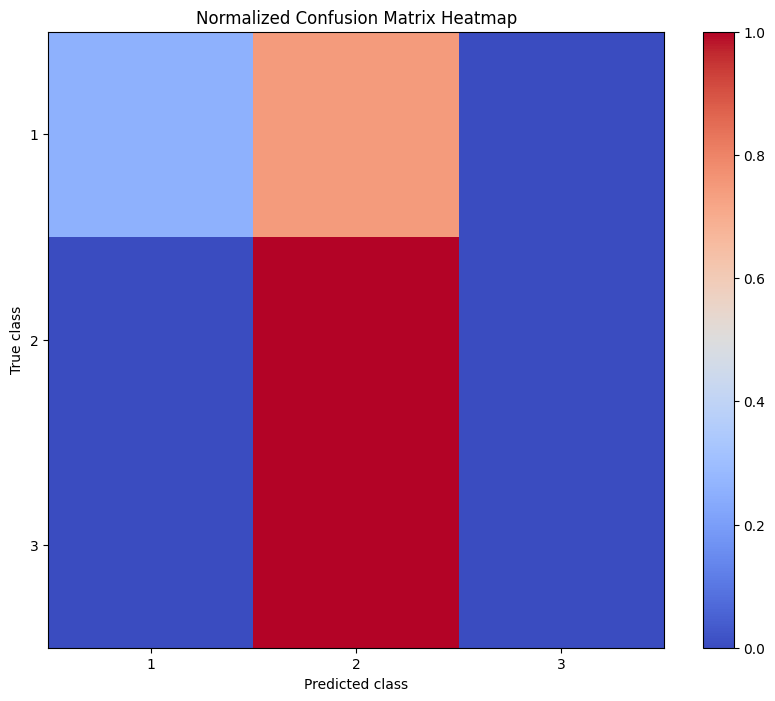

In [21]:
# build random forest
rdf = build_rdf(X_train_numpy, y_train_numpy, attribute_types, 5, options=50)

# make predictions on the test set
y_pred = predict_rdf(rdf, X_val_numpy)

# calculate accuracy
accuracy = accuracy_score(y_val_numpy, y_pred)
print("Accuracy:", accuracy)

# calculate confusion matrix
conf_matrix = confusion_matrix(y_val_numpy, y_pred, labels=labels, normalize="true")

# Create a heatmap for the normalized confusion matrix
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('coolwarm')
heatmap = plt.imshow(conf_matrix, cmap=cmap)
plt.colorbar(heatmap)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Normalized Confusion Matrix Heatmap')

# Show the plot
plt.show()


 Its accuracy is lower than AdaBoost. There is a tendency to predict the classes as the class 2. For the class 1, it doesn't predict very well. The class 3 still suffers from lack of data as it happened in AdaBoost.

In HW2, the class 3 also suffered from lack of data and the confusion matrices showed us the poor result of the class 3 prediction. However, they got a great result for the class 1 and 2. Using Perceptron instead of Information Gain decreased the accuracy.

Pre-pruning trees, the number of features, using the feature "Sex" might affect the result of this model as well.